# 特征提取

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os

## 说明：
此程序用于对dlib库以及LBP图像提取技术的学习测试

## 1. 人脸特征提取（dlib库）

#### 说明：此程序为使用dlib库做一张图片的特征提取的实验<br />
实验过程：<br />
1. 从rawdata中读取图像文件，转换为128*128、uint8编码的ndarray类型以及灰度格式转BGR格式<br />
2. 绘制原始图像<br />
3. 利用dlib库的人脸追踪模型得到人脸矩形，与原始图像一同绘制<br />
4. 利用dlib库的人脸68特征点提取模型得到特征点位置，在原始图像上描出68个特征点<br />
5. 利用dlib库将68个特征点转换成128个特征向量，打印出来

In [2]:
import dlib

导入人脸数据

In [3]:
with open("data/rawdata/1350", 'rb') as img_ori:  #将rawdata文件放在工作目录中
    img_data = np.frombuffer(img_ori.read(), dtype = np.uint8).reshape(128, 128)
    img_data = cv2.cvtColor(img_data, cv2.COLOR_GRAY2BGR)    #原图为灰度图，而dlib读取RGB图，故需要做格式转换
# print(img_data)
cv2.namedWindow('img1', cv2.WINDOW_FREERATIO|cv2.WINDOW_NORMAL)
cv2.imshow('img1', img_data)
cv2.waitKey(0)
cv2.destroyWindow('img1')

dlib.get_frontal_face_detector()人脸位置检测器，输入RGB图，输出框出人脸的矩形框所需要的四个坐标

In [4]:
detector = dlib.get_frontal_face_detector()    #获取人脸位置检测器
print(detector)
detect_face = detector(img_data, 1)    #1表示上采样，即将图片放大后再进行采样，能够捕获更精准的特征点
print(type(detect_face))
print(detect_face)
for index, face in enumerate(detect_face):    #通过循环拿出dectector的输出
    face_left = face.left()
    face_top = face.top()
    face_right = face.right()
    face_bottom = face.bottom()

cv2.rectangle(img_data, (face_left, face_top), (face_right, face_bottom), (0, 255, 0), 1)    #根据detector找出的四个点绘制矩形，红线、线宽为3
cv2.namedWindow('img2', cv2.WINDOW_FREERATIO|cv2.WINDOW_NORMAL)
cv2.imshow('img2', img_data)
cv2.waitKey(0)
cv2.destroyWindow('img2')

<class 'dlib.rectangles'>
rectangles[[(38, 46) (100, 108)]]


dlib.shape_predictor()提取人脸的68个特征点，需要由detector实现给出人脸框的四个坐标，以及“shape_predictor_68_face_landmarks.dat”模型

In [5]:
predictor = dlib.shape_predictor('dlib_package/shape_predictor_68_face_landmarks.dat')    #获取人脸68个特征点的模型
predict_shape = predictor(img_data, face)
for index, shape in enumerate(predict_shape.parts()):
    cv2.circle(img_data, (shape.x, shape.y), 1, (255, 0, 0))    #绘制68个特征点
cv2.namedWindow('img3', cv2.WINDOW_FREERATIO|cv2.WINDOW_NORMAL)
cv2.imshow('img3', img_data)
cv2.waitKey(0)
cv2.destroyWindow('img3')

dlib.face_recognition_model_v1()提取128个特征距离（未规范化），需要由predictor给出68个特征点，以及"dlib_face_recognition_resnet_model_v1.dat"模型

In [6]:
face_rec_model = dlib.face_recognition_model_v1('dlib_package/dlib_face_recognition_resnet_model_v1.dat')
descriptor_distance = face_rec_model.compute_face_descriptor(img_data, predict_shape)   # 计算人脸的128维的向量
# print(descriptor_distance)
face_distance = np.array(descriptor_distance)
print(face_distance)

[-0.1000465   0.13306737  0.05591539 -0.06922026 -0.1964432   0.03238436
 -0.01689178 -0.11732005  0.19914949 -0.10321921  0.21967758 -0.02643075
 -0.25252172  0.0291186   0.04807919  0.19822432 -0.16025046 -0.10505069
 -0.12618247 -0.09650042 -0.06692629  0.07742698  0.04409299  0.07389086
 -0.13898119 -0.24857882 -0.06048961 -0.10703573  0.05024409 -0.03424352
 -0.05738575  0.0830814  -0.13717403 -0.02989589  0.04121237  0.10495468
 -0.0839296  -0.09833761  0.13856891 -0.04393422 -0.15788238  0.0581252
  0.01913241  0.20650351  0.21663998 -0.02683786  0.07310195 -0.12450603
  0.11101779 -0.27646941  0.0961553   0.12880833  0.02655403  0.08162008
  0.07289537 -0.15787534 -0.03284181  0.18096878 -0.15694639  0.03384478
  0.12919064  0.01690003 -0.01874227 -0.13912623  0.20178297  0.14133939
 -0.13700333 -0.15843865  0.13284796 -0.17025897 -0.1001855   0.07743269
 -0.17394911 -0.17824323 -0.29285765  0.07873406  0.41269299  0.1888788
 -0.13072772 -0.01249288 -0.0575581  -0.02754962 -0.0

## 2. LBP局部二元模式处理

#### 说明：此程序是对一张图片做LBP局部二元模式处理及得到128维LBP统计直方图的实验

In [7]:
from skimage.feature import local_binary_pattern

导入人脸数据

In [8]:
with open("data/rawdata/2090", 'rb') as img_ori:  #将rawdata文件放在工作目录中
    img_data = np.frombuffer(img_ori.read(), dtype = np.uint8).reshape(128, 128) #处理为128*128的灰度图
# print(img_data)
cv2.namedWindow('img1', cv2.WINDOW_FREERATIO|cv2.WINDOW_NORMAL)
cv2.imshow('img1', img_data)
cv2.waitKey(0)
cv2.destroyWindow('img1')

对图像做LBP处理

In [9]:
img_LBP = local_binary_pattern(image=img_data, P=8, R=1, method='default')
img_LBP = img_LBP.astype(np.uint8)
print('img_LBP.shape = ', img_LBP.shape)

img_LBP.shape =  (128, 128)


查看LBP图像效果

In [10]:
cv2.namedWindow('img_LBP', cv2.WINDOW_FREERATIO|cv2.WINDOW_NORMAL)
cv2.imshow('img_LBP', img_LBP)
cv2.waitKey(0)
cv2.destroyWindow('img_LBP')

将得到LBP图像的128维统计直方图

In [44]:
hist_LBP = cv2.calcHist([img_LBP], channels=[0], mask=None, histSize=[128], ranges=[0,256])

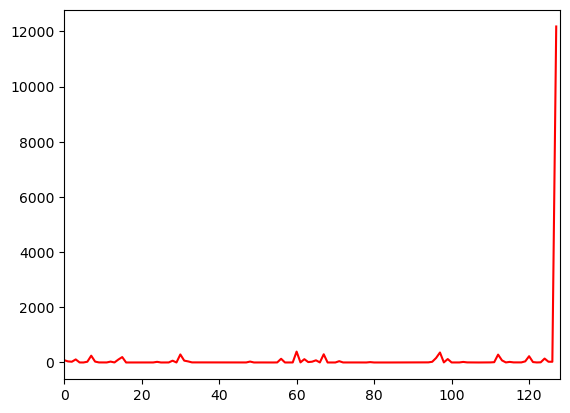

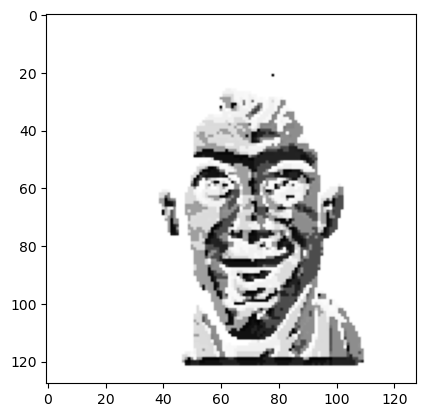

In [45]:
# hist_LBP = cv2.normalize(hist_LBP,hist_LBP)
plt.plot(hist_LBP, color='r')
plt.xlim([0,128])
plt.show()
plt.imshow(img_LBP,cmap='Greys_r')
plt.show()

去除黑色背景的影响

In [46]:
hist_LBP_std = hist_LBP[1:127]

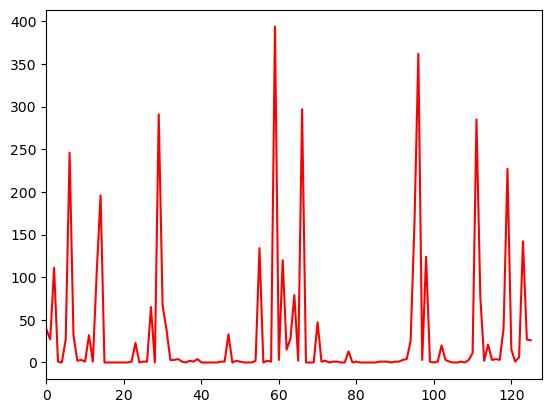

In [47]:
# hist_LBP = cv2.normalize(hist_LBP,hist_LBP)
plt.plot(hist_LBP_std, color='r')
plt.xlim([0,128])
plt.show()
plt.show()

## 3. 用dlib提取人脸，对人脸部分做LBP处理

In [48]:
def dlib_LBP(img_data) :
    detector = dlib.get_frontal_face_detector()    #获取人脸位置检测器
    img_data = cv2.cvtColor(img_data, cv2.COLOR_GRAY2BGR)    #原图为灰度图，而dlib读取RGB图，故需要做格式转换
    detect_face = detector(img_data, 1)    #1表示上采样，即将图片放大后再进行采样，能够捕获更精准的特征点
    for index, face in enumerate(detect_face):    #通过循环拿出dectector的输出
        dlib_left = face.left()
        dlib_top = face.top()
        dlib_right = face.right()
        dlib_bottom = face.bottom()
    img_out = img_data[dlib_top:dlib_bottom, dlib_left:dlib_right]
    img_out = cv2.resize(img_out, (64, 64), interpolation=cv2.INTER_CUBIC)
    img_out = cv2.cvtColor(img_out, cv2.COLOR_BGR2GRAY)   #转换回灰度图
    return img_out

In [51]:
img_dlib = dlib_LBP(img_data)
img_LBP = local_binary_pattern(image=img_dlib, P=8, R=1, method='default')
img_LBP = img_LBP.astype(np.uint8)
print('img_LBP.shape = ', img_LBP.shape)

img_LBP.shape =  (64, 64)


In [52]:
cv2.namedWindow('img_LBP', cv2.WINDOW_FREERATIO|cv2.WINDOW_NORMAL)
cv2.imshow('img_LBP', img_LBP)
cv2.waitKey(0)
cv2.destroyWindow('img_LBP')

In [53]:
hist_LBP = cv2.calcHist([img_LBP], channels=[0], mask=None, histSize=[128], ranges=[0,256])

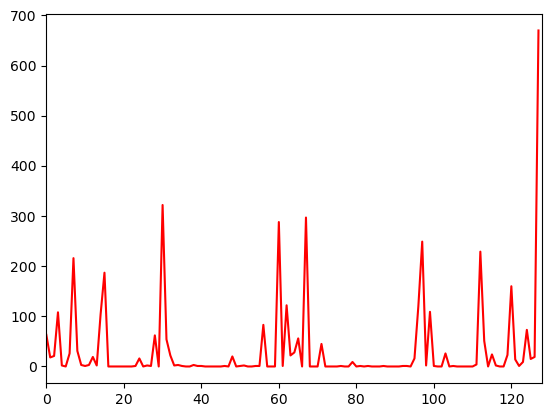

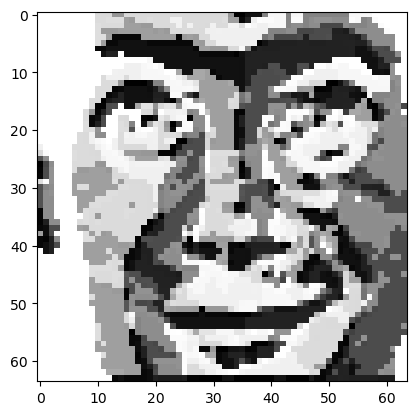

In [54]:
# hist_LBP = cv2.normalize(hist_LBP,hist_LBP)
plt.plot(hist_LBP, color='r')
plt.xlim([0,128])
plt.show()
plt.imshow(img_LBP,cmap='Greys_r')
plt.show()